# Análisis Exploratorio de los datos de Trocafone



### Propuestas


## Configuracion inicial

In [ ]:
#Importo librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')

In [ ]:
#Cargo el DataFrame
df = pd.read_csv('events.csv', low_memory=False)
df.head(5)

## Chequeos de integridad y calidad de los datos


In [ ]:
#Arreglo las fechas
df['timestamp']=pd.to_datetime(df['timestamp'])
df['timestamp'].head()

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
#Categorizo ciertas columnas para ahorrar espacio en memoria
for columna  in ['event','condition','storage', 'color', 'staticpage', 'campaign_source', 'search_engine', 'channel', 'new_vs_returning', 'region', 'country', 'device_type']:
        df[columna] = df[columna].astype('category')
df.info()


## Analisis

In [ ]:
# Cantidad de eventos que no especifican valor para country
df['country'].isna().sum()

In [ ]:
df['country'].value_counts().head(10)

La mayor parte de los eventos que especifican country provienen de Brasil

In [ ]:
#Veo para que eventos se especifica el pais
eventos_con_country = df[df['country'].notna()]
eventos_con_country['event'].value_counts().head()

El unico evento que especifica valor para country es "visited site"


In [ ]:
eventos_brasil = df[df['country'] == 'Brazil']
eventos_brasil['person'].value_counts().head()

In [ ]:
df.loc[df['event'] == 'visited site'].describe()

Text(0.5,1,'Cantidad de eventos por dia de la semana')

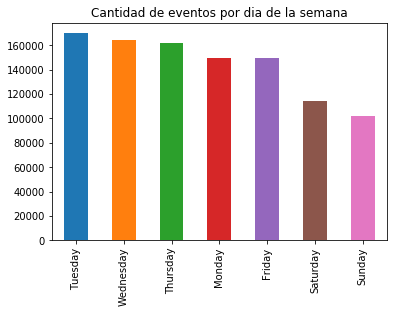

In [14]:
#Vamos a hacer un analisis sobre los dias en los que se produjeron los eventos
dias_semana = df['timestamp'].dt.weekday_name
g = dias_semana.value_counts().plot('bar')
g.set_title('Cantidad de eventos por dia de la semana')

## Analisis tipos de evento

In [ ]:
colUsadasEventos = df.groupby(by = 'event').count()
colUsadasEventos

In [ ]:
columns = list(df)
for event, row in colUsadasEventos.iterrows():
    print(event, end = ':')
    
    for column in columns:
        if(row.get(column) != 0):
            print(' ' + column, end = ',')
            
    print('\n')

## Columnas usadas por cada evento

Todos los eventos contienen informacion sobre **'timestamp'**, **'event'** y **'person'**, y ademas utilizan las siguientes columnas:

#### ad campaign hit:
    url, campaign_source
#### brand listing:
    skus
#### checkout: 
    sku, model, condition, storage, color

#### conversion: 
    sku, model, condition, storage, color

#### generic listing: 
    skus

#### lead: 
    model

#### search engine hit: 
    search_engine

#### searched products: 
    skus, search_term

#### staticpage: 
    staticpage

#### viewed product: 
    sku, model, condition, storage, color

#### visited site: 
    channel, new_vs_returning, city, region, country, device_type, screen_resolution, operating_system_version, browser_version
